In [1]:
# =========================================================
# 0) Setup (Colab installs) + Utilities
# =========================================================
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install numpy pandas scikit-learn einops tqdm
!pip -q install kagglehub tensorflow

import os, math, random, glob
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import average_precision_score, precision_recall_curve

def set_seed(seed=1337):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(1337)

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
print("Device:", device)


Device: cpu


In [2]:
# =========================================================
# 1) Data: use existing NPZ tiles; if missing, build from Kaggle TFRecords
# =========================================================
NPZ_ROOT = "/content/wildfire_npz_tiles_kaggle_v3"

def have_npz(root):
    return len(glob.glob(os.path.join(root, "*.npz"))) > 0

if not have_npz(NPZ_ROOT):
    print("No NPZ tiles found — converting from Kaggle TFRecords...")
    import kagglehub, tensorflow as tf

    path = kagglehub.dataset_download("fantineh/next-day-wildfire-spread")
    print("Kaggle dataset path:", path)
    tfrecs = sorted(glob.glob(os.path.join(path, "*.tfrecord")))
    assert len(tfrecs) > 0, "No TFRecords found in Kaggle dataset."

    os.makedirs(NPZ_ROOT, exist_ok=True)

    # Known feature keys (float_list length 4096 each; 64x64)
    keys = ['tmmn','NDVI','FireMask','population','elevation','vs','pdsi','pr','tmmx','sph','th','PrevFireMask','erc']

    def read_flat_float32(feat):
        fl = feat.float_list.value
        if len(fl) == 0: return None
        arr = np.asarray(fl, dtype=np.float32)
        if arr.size == 4096:
            return arr.reshape(64,64)
        s = int(round(math.sqrt(arr.size)))
        assert s*s == arr.size, f"Unexpected length {arr.size}"
        return arr.reshape(s, s)

    def wind_uv(vs, th):
        th_rad = th.copy()
        if np.nanmax(th_rad) > 6.4:      # degrees → radians
            th_rad = np.deg2rad(th_rad % 360.0)
        u = vs * np.cos(th_rad); v = vs * np.sin(th_rad)
        return u.astype(np.float32), v.astype(np.float32)

    def slope_aspect_from_elevation(z):
        gy, gx = np.gradient(z.astype(np.float32))
        mag = np.sqrt(gx**2 + gy**2)
        q95 = np.percentile(mag, 95) + 1e-6
        slope  = np.clip(mag / q95, 0, 1).astype(np.float32)
        aspect = np.arctan2(-gy, -gx).astype(np.float32)  # [-pi, pi]
        return slope, aspect

    def rh_proxy_from_sph(sph, tmmn, tmmx):
        s95 = np.percentile(sph, 95) + 1e-6
        rh = np.clip(sph / s95, 0, 1)
        tr = np.clip((tmmx - tmmn), 0, 30) / 30.0
        rh = np.clip(rh * (1.0 - 0.5*tr), 0, 1).astype(np.float32)
        return rh

    def barrier_from_population(pop):
        pop = np.clip(pop, 0, None).astype(np.float32)
        thr = np.percentile(pop, 90)
        return (pop >= thr).astype(np.float32)

    converted = 0
    for f in tqdm(tfrecs, desc="Converting TFRecords → NPZ"):
        for raw in tf.data.TFRecordDataset(f):
            ex = tf.train.Example.FromString(raw.numpy()).features.feature
            A = {k: read_flat_float32(ex[k]) if k in ex else None for k in keys}
            if A["PrevFireMask"] is None or A["FireMask"] is None:
                continue

            prev_fire = (A["PrevFireMask"] > 0.5).astype(np.float32)
            next_fire = (A["FireMask"]    > 0.5).astype(np.float32)
            tmmn = A["tmmn"] if A["tmmn"] is not None else np.full((64,64), 290, np.float32)
            tmmx = A["tmmx"] if A["tmmx"] is not None else np.full((64,64), 300, np.float32)
            temp = ((tmmn + tmmx)/2.0).astype(np.float32)

            vs = A["vs"] if A["vs"] is not None else np.zeros((64,64), np.float32)
            th = A["th"] if A["th"] is not None else np.zeros((64,64), np.float32)
            u, v = wind_uv(vs, th)

            ndvi = A["NDVI"] if A["NDVI"] is not None else np.full((64,64), 0.5, np.float32)
            if ndvi.min() < 0:  # map [-1,1] → [0,1]
                ndvi = np.clip((ndvi + 1.0)/2.0, 0, 1).astype(np.float32)

            sph = A["sph"] if A["sph"] is not None else np.zeros((64,64), np.float32)
            rh  = rh_proxy_from_sph(sph, tmmn, tmmx)

            elev = A["elevation"] if A["elevation"] is not None else np.zeros((64,64), np.float32)
            slope, aspect = slope_aspect_from_elevation(elev)

            pop = A["population"] if A["population"] is not None else np.zeros((64,64), np.float32)
            barrier = barrier_from_population(pop)

            fields = dict(
                prev_fire=prev_fire, next_fire=next_fire,
                u=u, v=v, temp=temp, rh=rh, ndvi=ndvi,
                slope=slope, aspect=aspect, barrier=barrier
            )

            sid_feat = ex.get("sample_id", None)
            if sid_feat and len(sid_feat.bytes_list.value) > 0:
                sid = sid_feat.bytes_list.value[0].decode("utf-8")
            else:
                sid = f"{os.path.basename(f)}_{converted:07d}"

            np.savez(os.path.join(NPZ_ROOT, f"{sid}.npz"), **fields)
            converted += 1

    print(f"Converted {converted} tiles → {NPZ_ROOT}")
else:
    print(f"Using existing NPZ tiles at {NPZ_ROOT} (found {len(glob.glob(os.path.join(NPZ_ROOT, '*.npz')))} files)")


No NPZ tiles found — converting from Kaggle TFRecords...


100%|██████████| 2.08G/2.08G [00:23<00:00, 96.3MB/s]

Extracting files...


Kaggle dataset path: /root/.cache/kagglehub/datasets/fantineh/next-day-wildfire-spread/versions/2


Converting TFRecords → NPZ:   0%|          | 0/19 [00:00<?, ?it/s]

Converted 18545 tiles → /content/wildfire_npz_tiles_kaggle_v3


In [3]:
# =========================================================
# 2) Dataset & Loaders (no spatial context baseline)
# =========================================================
@dataclass
class WildfirePaths:
    root: str

class WildfireDataset(Dataset):
    def __init__(self, paths:WildfirePaths, split="train", max_samples=None, seed=1337):
        self.paths = paths
        all_files = sorted(glob.glob(os.path.join(paths.root, "*.npz")))
        if len(all_files) == 0:
            raise ValueError(f"No .npz files in {paths.root}")
        rng = np.random.default_rng(seed); rng.shuffle(all_files)
        n = len(all_files); n_train = int(round(0.70*n)); n_val = int(round(0.15*n))
        if split == "train":
            sel = np.arange(0, max(1,n_train))
        elif split == "val":
            sel = np.arange(n_train, max(n_train+1, n_train+n_val))
        elif split == "test":
            sel = np.arange(n_train+n_val, n) if (n_train+n_val)<n else np.arange(n-1,n)
        else:
            raise ValueError("split must be train|val|test")
        files = [all_files[i] for i in sel]
        if max_samples: files = files[:max_samples]
        if len(files)==0: files=[all_files[0]]
        self.files = files

    def __len__(self): return len(self.files)

    def __getitem__(self, i):
        arr = np.load(self.files[i])
        required = ["prev_fire","next_fire","u","v","temp","rh","ndvi","slope","aspect"]
        missing = [k for k in required if k not in arr]
        if missing: raise KeyError(f"{os.path.basename(self.files[i])} missing keys: {missing}")

        prev_fire = arr["prev_fire"][None,...].astype(np.float32)
        next_fire = arr["next_fire"][None,...].astype(np.float32)
        u   = arr["u"][None,...].astype(np.float32)
        v   = arr["v"][None,...].astype(np.float32)
        temp= arr["temp"][None,...].astype(np.float32)
        rh  = arr["rh"][None,...].astype(np.float32)
        ndvi= arr["ndvi"][None,...].astype(np.float32)
        slope = arr["slope"][None,...].astype(np.float32)
        aspect= arr["aspect"][None,...].astype(np.float32)
        barrier = (arr["barrier"][None,...].astype(np.float32)
                   if "barrier" in arr else np.zeros_like(prev_fire))

        # 9 raw channels; we'll normalize these for the LR model
        X_raw = np.concatenate([prev_fire,u,v,temp,rh,ndvi,slope,aspect,barrier], axis=0)
        y = next_fire
        return {"X_raw": torch.from_numpy(X_raw), "y": torch.from_numpy(y)}

# build splits
paths = WildfirePaths(NPZ_ROOT)
train_ds = WildfireDataset(paths, split="train", max_samples=1200)
val_ds   = WildfireDataset(paths, split="val",   max_samples=300)
test_ds  = WildfireDataset(paths, split="test",  max_samples=300)

def make_loader(ds, batch_size=16, upweight_positive=False, shuffle=False):
    if upweight_positive:
        weights = []
        for f in ds.files:
            y = np.load(f)["next_fire"]
            weights.append(5.0 if y.sum()>0 else 1.0)
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
        return DataLoader(ds, batch_size=batch_size, sampler=sampler,
                          num_workers=0, pin_memory=use_cuda, persistent_workers=False)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle,
                      num_workers=0, pin_memory=use_cuda, persistent_workers=False)

train_loader = make_loader(train_ds, batch_size=16, upweight_positive=True)
val_loader   = make_loader(val_ds,   batch_size=16, upweight_positive=False, shuffle=False)
test_loader  = make_loader(test_ds,  batch_size=16, upweight_positive=False, shuffle=False)


In [4]:
# =========================================================
# 3) Channel Stats (normalize the 9 original features)
# =========================================================
@torch.no_grad()
def compute_channel_stats(ds, n_max=None):
    sums = np.zeros(9, dtype=np.float64); sqs = np.zeros(9, dtype=np.float64); count = 0
    loader = DataLoader(ds, batch_size=32, shuffle=False, num_workers=0)
    for i, b in enumerate(loader):
        x = b["X_raw"].numpy()  # (B,9,H,W)
        B,C,H,W = x.shape
        x = x.reshape(B, C, -1)
        sums += x.sum(axis=(0,2)); sqs += (x**2).sum(axis=(0,2)); count += B*H*W
        if n_max and (i+1)*B >= n_max: break
    mean = sums / count
    var  = sqs / count - mean**2
    std  = np.sqrt(np.maximum(var, 1e-8))
    # don't normalize prev_fire & barrier
    std[[0,8]] = 1.0
    return torch.tensor(mean, dtype=torch.float32), torch.tensor(std, dtype=torch.float32)

mean9, std9 = compute_channel_stats(train_ds)
mean9, std9 = mean9.to(device), std9.to(device)
mean9, std9

(tensor([ 8.6530e-03, -1.4194e+00, -7.7096e-01,  2.8970e+02,  6.8273e-01,
          2.8712e+03,  4.0586e-01, -2.9040e-01,  1.0478e-01]),
 tensor([1.0000e+00, 2.2510e+00, 2.8355e+00, 1.8461e+01, 9.0152e-02, 3.1485e+03,
         2.7670e-01, 1.8294e+00, 1.0000e+00]))

In [5]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv)
# =========================================================
class PixelLogReg(nn.Module):
    def __init__(self, in_ch=9):
        super().__init__()
        self.lin = nn.Conv2d(in_ch, 1, kernel_size=1, bias=True)
    def forward(self, x):
        return self.lin(x)  # logits (B,1,H,W)

def build_lr_input(X_raw0):
    # normalize only the 9 original raw channels
    return (X_raw0 - mean9.view(1,-1,1,1)) / std9.view(1,-1,1,1)

@torch.no_grad()
def pos_weight_from_loader(loader, max_batches=100):
    total_pos = 0
    total = 0
    for i, b in enumerate(loader):
        y = b["y"]
        total_pos += y.sum().item()
        total     += y.numel()
        if i+1 >= max_batches: break
    pos = max(total_pos, 1.0)
    neg = max(total - total_pos, 1.0)
    return torch.tensor(neg / pos, dtype=torch.float32, device=device)

lr_model = PixelLogReg(in_ch=9).to(device)
pw = pos_weight_from_loader(train_loader)
criterion = nn.BCEWithLogitsLoss(pos_weight=pw)

optimizer = torch.optim.AdamW(lr_model.parameters(), lr=1e-3, weight_decay=1e-4)
EPOCHS_LR = 5  # usually enough for convergence
print("pos_weight =", float(pw))


pos_weight = 80.69805145263672


In [6]:
# =========================================================
# 5) Train / Eval loops
# =========================================================
def train_lr_epoch():
    lr_model.train()
    losses=[]
    for b in tqdm(train_loader, desc="train LR", leave=False):
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        logits = lr_model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        losses.append(loss.item())
    return float(np.mean(losses))

@torch.no_grad()
def eval_lr(loader):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(loader, desc="eval LR", leave=False):
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p); all_t.append(t)
    p = np.concatenate(all_p); t = np.concatenate(all_t)
    if t.sum()==0:
        return 0.0, 0.0, 0.5
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2*prec*rec)/(prec+rec+1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    return float(ap), float(f1.max()), float(best_thr)

best_val_ap_lr = -1.0
for e in range(EPOCHS_LR):
    tr = train_lr_epoch()
    ap, f1, thr = eval_lr(val_loader)
    print(f"[LR] Epoch {e:02d} | loss {tr:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | thr≈{thr:.3f}")
    best_val_ap_lr = max(best_val_ap_lr, ap)

# Final test using threshold picked on VAL
_, _, best_thr_val = eval_lr(val_loader)

@torch.no_grad()
def test_at_thr(thr):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(test_loader, desc="test LR", leave=False):
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p); all_t.append(t)
    p = np.concatenate(all_p); t = np.concatenate(all_t)
    ap = average_precision_score(t, p)
    yhat = (p >= thr).astype(np.float32)
    tp = (yhat*t).sum(); fp = (yhat*(1-t)).sum(); fn = ((1-yhat)*t).sum()
    prec = tp/(tp+fp+1e-8); rec = tp/(tp+fn+1e-8)
    f1 = 2*prec*rec/(prec+rec+1e-8)
    print(f"[LR] TEST @thr={thr:.3f} | AP={ap:.4f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f}")
    return ap, f1

test_ap_lr, test_f1_lr = test_at_thr(best_thr_val)


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 00 | loss 1.4948 | VAL AP 0.0100 | VAL F1* 0.0213 | thr≈0.604


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 01 | loss 1.4205 | VAL AP 0.0132 | VAL F1* 0.0330 | thr≈0.606


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 02 | loss 1.3734 | VAL AP 0.0221 | VAL F1* 0.0700 | thr≈0.592


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 03 | loss 1.3753 | VAL AP 0.0337 | VAL F1* 0.1174 | thr≈0.596


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 04 | loss 1.3859 | VAL AP 0.0357 | VAL F1* 0.1188 | thr≈0.615


eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

test LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] TEST @thr=0.615 | AP=0.0342 | P=0.066 R=0.211 F1=0.100



[LR] Coefficients (sorted by |weight|):
  prev          +0.3885
  rh            -0.1708
  barrier       -0.1343
  v             -0.1135
  slope         +0.0536
  temp          -0.0428
  aspect(rad)   +0.0298
  u             +0.0154
  ndvi          +0.0036
[LR] Bias: +0.0387


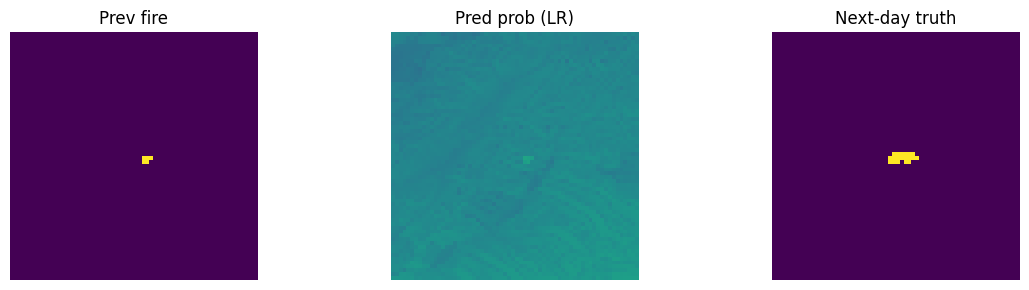

In [7]:
# =========================================================
# 6) Inspect coefficients + quick viz
# =========================================================
with torch.no_grad():
    W = lr_model.lin.weight[0,:,0,0].detach().cpu().numpy()  # shape (9,)
    B = lr_model.lin.bias.item()
channel_names = ["prev","u","v","temp","rh","ndvi","slope","aspect(rad)","barrier"]
coef = sorted([(channel_names[i], float(W[i])) for i in range(9)], key=lambda x: -abs(x[1]))
print("\n[LR] Coefficients (sorted by |weight|):")
for name,w in coef:
    print(f"  {name:12s}  {w:+.4f}")
print(f"[LR] Bias: {B:+.4f}")

# quick qualitative visualization
import matplotlib.pyplot as plt
@torch.no_grad()
def show_one_lr(ds, i=0):
    b = ds[i]
    X_raw0 = b["X_raw"].unsqueeze(0).to(device)
    y = b["y"][0].numpy()
    X = build_lr_input(X_raw0)
    prob = torch.sigmoid(lr_model(X))[0,0].cpu().numpy()
    fig,axs = plt.subplots(1,3, figsize=(12,3))
    axs[0].imshow(b["X_raw"][0], vmin=0, vmax=1); axs[0].set_title("Prev fire")
    axs[1].imshow(prob, vmin=0, vmax=1);          axs[1].set_title("Pred prob (LR)")
    axs[2].imshow(y, vmin=0, vmax=1);             axs[2].set_title("Next-day truth")
    for a in axs: a.axis('off')
    plt.tight_layout(); plt.show()

show_one_lr(test_ds, i=0)


In [8]:
# =========================================================
# 7) Save artifacts (optional)
# =========================================================
os.makedirs("/content/artifacts_lr", exist_ok=True)
torch.save({"state_dict": lr_model.state_dict(),
            "mean9": mean9.cpu(),
            "std9": std9.cpu(),
            "pos_weight": float(pw)},
           "/content/artifacts_lr/pixel_logreg.pt")
print("Saved model → /content/artifacts_lr/pixel_logreg.pt")


Saved model → /content/artifacts_lr/pixel_logreg.pt


In [9]:
test_ap_lr, test_f1_lr


(np.float64(0.0341531836687037), np.float32(0.09998224))

In [10]:
from sklearn.metrics import confusion_matrix

# choose threshold on VAL (already in your code)
val_ap, val_f1, best_thr_val = eval_lr(val_loader)
print(f"[LR] VAL: AP={val_ap:.4f} F1*={val_f1:.4f} thr≈{best_thr_val:.3f}")

@torch.no_grad()
def confusion_at_thr(loader, thr):
    lr_model.eval()
    ps, ts = [], []
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p); ts.append(t)
    p = np.concatenate(ps); t = np.concatenate(ts)
    yhat = (p >= thr).astype(np.float32)
    tn, fp, fn, tp = confusion_matrix(t, yhat).ravel()
    prec = tp/(tp+fp+1e-8); rec = tp/(tp+fn+1e-8)
    f1 = 2*prec*rec/(prec+rec+1e-8)
    return dict(tp=int(tp), fp=int(fp), tn=int(tn), fn=int(fn),
                precision=float(prec), recall=float(rec), f1=float(f1))

print("VAL @thr:", confusion_at_thr(val_loader, best_thr_val))
print("TEST @thr:", confusion_at_thr(test_loader, best_thr_val))


eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] VAL: AP=0.0357 F1*=0.1188 thr≈0.615
VAL @thr: {'tp': 2039, 'fp': 20514, 'tn': 1196525, 'fn': 9722, 'precision': 0.09040925819177474, 'recall': 0.17336961142745227, 'f1': 0.11884361617411077}
TEST @thr: {'tp': 3098, 'fp': 44160, 'tn': 1169927, 'fn': 11615, 'precision': 0.06555503830037972, 'recall': 0.21056208794928935, 'f1': 0.09998224614094468}


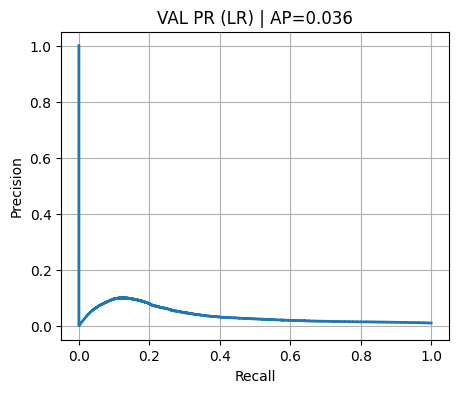

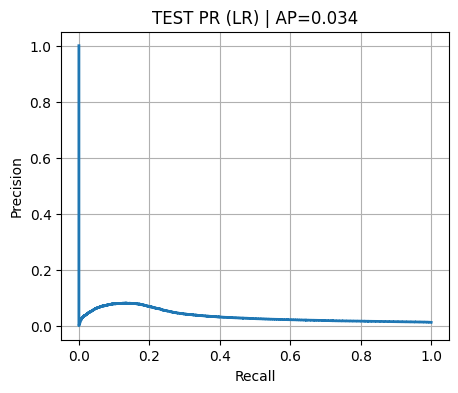

In [11]:
import matplotlib.pyplot as plt
@torch.no_grad()
def pr_curve(loader, title="PR Curve (LR)"):
    lr_model.eval()
    ps, ts = [], []
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p); ts.append(t)
    p = np.concatenate(ps); t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True); plt.show()

pr_curve(val_loader, "VAL PR (LR)")
pr_curve(test_loader, "TEST PR (LR)")


In [12]:
# Single-feature AUC-style check via LR trained with 1 channel at a time
single_feats = ["prev","u","v","temp","rh","ndvi","slope","aspect(rad)","barrier"]

@torch.no_grad()
def eval_single_feature(idx):
    # copy weights; zero all but idx
    W = lr_model.lin.weight.data.clone()
    b = lr_model.lin.bias.data.clone()
    wf = torch.zeros_like(W); wf[0, idx, 0, 0] = W[0, idx, 0, 0]
    lr_model.lin.weight.data = wf
    ap, f1, _ = eval_lr(val_loader)
    lr_model.lin.weight.data = W; lr_model.lin.bias.data = b
    return ap, f1

abl = []
for i,nm in enumerate(single_feats):
    ap_i, f1_i, = eval_single_feature(i)[:2]
    abl.append((nm, ap_i, f1_i))
abl = sorted(abl, key=lambda x: -x[2])
print("\n[LR] Single-feature VAL ablations (sorted by F1):")
for nm, ap_i, f1_i in abl:
    print(f"  {nm:12s}  AP={ap_i:.3f}  F1*={f1_i:.3f}")


eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]


[LR] Single-feature VAL ablations (sorted by F1):
  prev          AP=0.093  F1*=0.292
  v             AP=0.014  F1*=0.055
  slope         AP=0.012  F1*=0.026
  rh            AP=0.012  F1*=0.025
  ndvi          AP=0.009  F1*=0.022
  aspect(rad)   AP=0.010  F1*=0.021
  u             AP=0.009  F1*=0.020
  barrier       AP=0.010  F1*=0.020
  temp          AP=0.008  F1*=0.020
